In [6]:
"""
1. Make a simple bigram model
2. Do a mlp model
2. Do a wavenet model
3. Do a GPT model
"""
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import torch
from torch import nn
from dataclasses import dataclass
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
from gpt.bigram import BiGram, MLP, WaveNet
from gpt.data import TextDataset
from gpt.wavenet import make_wavenet
from gpt.utils import model_info

@torch.no_grad()
@torch.inference_mode()
def eval(device):
    losses = []
    for X, Y in iter(dl_val):
        X = X.to(device)
        Y = Y.to(device)
        y_logit, loss = model(X, Y)
        losses.append(loss.item())
    return torch.mean(torch.tensor(losses)).item()


In [16]:
# !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

batch_size=32
block_size=8
n_embd=24
n_hidden=128

In [17]:
ds_train = TextDataset('names.txt','train', block_size=block_size)
ds_val = TextDataset('names.txt','val', block_size=block_size)

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True)
vocab_size = len(ds_train.vocab)

In [35]:
# model = make_wavenet(vocab_size, n_embd=24,n_hidden=128)
model = MLP(vocab_size, block_size, n_embd, n_hidden)
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# model info
x = next(iter(dl_train))[0]
model_info(model, x)

62627


,name,out_size,params,nparams
0,X,"(32, 8)",NaN,NaN
1,Embedding,"(32, 8, 24)","{'weight': (27, 24)}",648.0
2,Flatten,"(32, 192)",{},0.0
3,Linear,"(32, 128)","{'weight': (128, 192), 'bias': (128,)}",24704.0
4,BatchNorm1d,"(32, 128)","{'weight': (128,), 'bias': (128,)}",256.0
5,Tanh,"(32, 128)",{},0.0
6,Linear,"(32, 128)","{'weight': (128, 128), 'bias': (128,)}",16512.0
7,BatchNorm1d,"(32, 128)","{'weight': (128,), 'bias': (128,)}",256.0
8,Tanh,"(32, 128)",{},0.0
9,Linear,"(32, 128)","{'weight': (128, 128), 'bias': (128,)}",16512.0


In [33]:
df

,name,out_size,nparams,params
0,X,"(32, 8)",NaN,NaN
1,Embedding,"(32, 8, 24)",648.0,"{'weight': (27, 24)}"
2,Flatten,"(32, 192)",0.0,{}
3,Linear,"(32, 128)",24704.0,"{'weight': (128, 192), 'bias': (128,)}"
4,BatchNorm1d,"(32, 128)",256.0,"{'weight': (128,), 'bias': (128,)}"
5,Tanh,"(32, 128)",0.0,{}
6,Linear,"(32, 128)",16512.0,"{'weight': (128, 128), 'bias': (128,)}"
7,BatchNorm1d,"(32, 128)",256.0,"{'weight': (128,), 'bias': (128,)}"
8,Tanh,"(32, 128)",0.0,{}
9,Linear,"(32, 128)",16512.0,"{'weight': (128, 128), 'bias': (128,)}"


In [164]:
logits.shape

torch.Size([32, 8, 27])

In [165]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  # ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  # Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  ix = torch.randint(0, len(ds_train)-1, (batch_size,))
  # Xb, Yb = [ds_train[ix_] for ix_ in ix] # batch X,Y
  Xb, Yb = zip(*[ds_train[ix_] for ix_ in ix])
  Xb = torch.stack(Xb, 0)
  Yb = torch.stack(Yb, 0)
  Yb = Yb[:, -1]
  
  # forward pass
  logits, loss = model(Xb, Yb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3170
  10000/ 200000: 3.3204
  20000/ 200000: 3.3157


KeyboardInterrupt: 

In [201]:
device = torch.device("cuda")
# model = BiGram(vocab_size)
model = MLP(vocab_size, block_size=block_size, n_embd=n_embd, n_hidden=n_hidden)
# model = WaveNetDemo(vocab_size, n_embd=24,n_hidden=128)
model = model.to(device)
if hasattr(model,'seq'):
    with torch.no_grad():
      model.seq[-1].weight *= 0.1 # last layer make less confident

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150000)
train_losses = []
val_losses = {}

In [208]:
y_logit.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [211]:
# n_steps = 100000
max_epochs = 100
eval_freq = 1000
step = 0
done = False
for epoch in range(1, max_epochs+1):
    for i, (X,Y) in enumerate(iter(dl_train), start=1):
        step += 1
        # break
        X = X.to(device)
        Y = Y.to(device)
        y_logit,loss = model(X, Y)
        
        # break
        
        optimizer.zero_grad(True)
        loss.backward()
        optimizer.step()
        scheduler.step()
    
        if step == 0 or step % eval_freq == 0:
            val_loss = eval(device)
            val_losses[step] = val_loss
            lr = optimizer.param_groups[0]['lr']
            print(f'{epoch}:{i}|s={step} loss: {loss.item()} val_loss: {val_loss} lr: {lr}')
            
        train_losses.append(float(loss))
                
    print('epoch done')


1:1000|s=1000 loss: 2.3888566493988037 val_loss: 2.3300578594207764 lr: 0.01
1:2000|s=2000 loss: 2.1664392948150635 val_loss: 2.2453510761260986 lr: 0.01
1:3000|s=3000 loss: 2.048384666442871 val_loss: 2.238759994506836 lr: 0.01
1:4000|s=4000 loss: 2.1166439056396484 val_loss: 2.228214740753174 lr: 0.01
1:5000|s=5000 loss: 1.9491580724716187 val_loss: 2.186807632446289 lr: 0.01
1:6000|s=6000 loss: 2.2257020473480225 val_loss: 2.142014265060425 lr: 0.01
epoch done
2:583|s=7000 loss: 1.8910250663757324 val_loss: 2.137589454650879 lr: 0.01
2:1583|s=8000 loss: 2.255828619003296 val_loss: 2.1428544521331787 lr: 0.01
2:2583|s=9000 loss: 1.9945025444030762 val_loss: 2.097355842590332 lr: 0.01
2:3583|s=10000 loss: 2.1658809185028076 val_loss: 2.072314977645874 lr: 0.01
2:4583|s=11000 loss: 2.3506972789764404 val_loss: 2.0943987369537354 lr: 0.01
2:5583|s=12000 loss: 2.382546901702881 val_loss: 2.0889217853546143 lr: 0.01
epoch done
3:166|s=13000 loss: 1.9394550323486328 val_loss: 2.06950354576

KeyboardInterrupt: 

In [212]:
# list(model.parameters())[0].var(0)

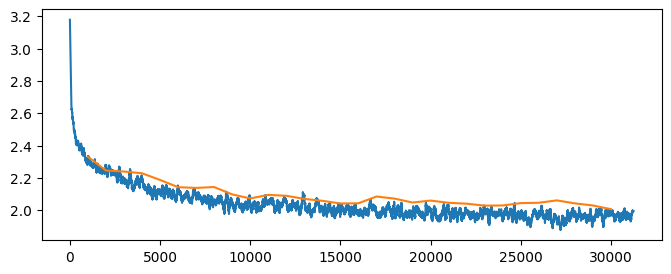

In [213]:
from scipy.signal import savgol_filter
train_losses_smoothed = savgol_filter(train_losses, 100, 1)
fig, ax = plt.subplots(1,1,figsize=(8,3))
i = list(range(0, len(train_losses), eval_freq))
ax.plot(train_losses_smoothed)
ax.plot(val_losses.keys(),val_losses.values())

In [214]:
ds_val[0]

(tensor([14, 21,  5, 12,  0,  1, 14, 19]),
 tensor([21,  5, 12,  0,  1, 14, 19, 21]))

In [218]:
x.ndim

2

In [219]:
x = ds_val[0][0].unsqueeze(0)
y_pred = model.predict(X, 1000)
print(''.join(ds_train.decode(y_pred[0])))

shewn
shenion
rainon
amirie
amergh
anmion
ayryo
giard
jeghen
jencorsem
cepaji
enriphon
ryedeni
conelys
parrems
wam
harjalea
jaleeth
jalelan
jamann
jatrion
jason
jazler
jona
lyn
calna
donisa
taphu
vanhel
valyy
xiloa
tikhio
tichorwa
harae
nahaley
malisyi
makalla
makynne
matiah
merion
melenah
mareem
dakia
deamarie
caolinn
chayon
crreila
creydeda
kyleena
kaliz
chaslenn
karir
landa
laedjollani
yolach
ken
reila
rhelisse
elena
emilee
eliighaele
shaio
shono
cherend
chifar
chino
sterh
tameleede
naviaa
nezie

staesh
sofl
zabno
zeedelle
nieela
haeshali
anrari
anarii
azara
ajeylon
neyua
demenn
danyla
damiya
daylion
daxta
dosana
danalyn
deleen
emaanie
karalay
kavion
kayorete
kalandhas
fryn
garrerna
andeitha
gumita
gambet
galix
garculo

vallee
nallie
navelin

ajiaahi
jizaay
jezlee
jebeth
jerden
jenelil
joeta
jolel
joz
elzoa
zeleyah
kalel
habryly
naelalus
ster
yedha
zevana
zayxon
zaxka
zelii
zejel
zeak
leja
belen
jelon
joleten
jofer
joyleni
jozalen
juhbyne
kachl
keter
kelella
kalynnio
jelvien
ircyar


In [217]:
%debug 

> /mnt/hdd2/userdata/egafni/projects/GPT/gpt/bigram.py(23)predict()
     21             y_logit, loss = self(X)
     22             assert isinstance(y_logit, torch.Tensor)
---> 23             y_proba = torch.softmax(y_logit, axis=2)
     24             next_token = torch.multinomial(y_proba[:, -1, :], num_samples=1)
     25             X = torch.cat([X[:, 1:], next_token], axis=1)



ipdb>  y_logit


tensor([[-2.7631e+00,  9.9062e-01, -3.3537e-01, -9.0765e-01, -4.8481e-01,
         -2.2454e-01, -1.8219e+00, -6.2908e-02, -1.1588e+00, -1.5960e+00,
         -1.9196e+00, -3.9353e-01,  1.5247e+00,  1.7489e-01,  6.4097e-01,
          8.1899e-01,  1.6525e-01,  1.0941e+00,  3.6124e+00,  1.9773e+00,
          1.0520e+00, -1.1566e+00,  3.5627e-01, -1.8867e+00, -3.9479e-01,
          1.8337e-01,  2.8279e-01],
        [ 1.2643e+00,  7.5333e-01, -5.1790e-01, -1.7604e+00, -1.2357e+00,
          8.3414e-01, -2.1037e+00, -2.7824e+00, -1.4906e+00, -2.2694e-03,
         -2.9240e+00, -1.6971e+00,  3.2932e+00,  6.1414e-01,  2.7654e+00,
         -1.1716e+00, -2.9617e+00, -3.8996e+00,  1.0703e+00, -1.6041e-01,
         -3.0540e-01, -2.5644e+00, -1.8339e+00, -4.0383e+00, -2.9988e+00,
          4.4717e-01, -5.9124e-01],
        [ 6.3073e-01,  3.7418e+00, -3.3771e+00, -1.4789e+00, -1.5102e+00,
          3.7167e+00, -3.1904e+00, -3.1646e+00, -7.6849e-01,  4.1494e+00,
         -2.4173e+00, -2.6876e+00, -2.16

ipdb>  y_logit.shape


torch.Size([32, 27])


ipdb>  y_logit.shape


torch.Size([32, 27])


ipdb>  q


In [121]:
X.shape

torch.Size([9, 8])

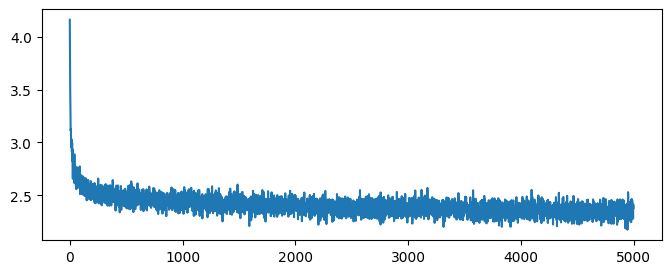

In [20]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(torch.as_tensor(losses).view(-1, 20).mean(1))

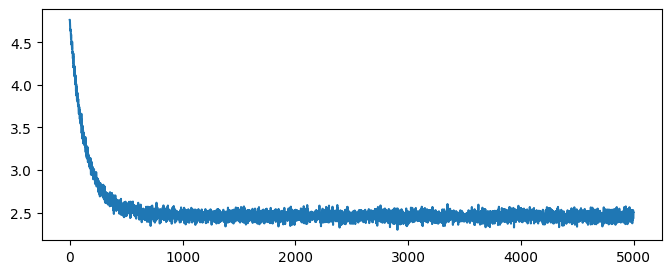

In [235]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(torch.as_tensor(losses).view(-1, 20).mean(1))

In [239]:
''.join(ds_train.decode(model.predict(X, 1000)[0]))

"rifave tentha n is il tinoue, l ie s tot SAnt fos oowi'ste n cilld harr tet; be s h grors ake, he kik\nF f foxthe iverrfeoran ce fisin suean;\nhe: w honous, gen har warry s, t horol mbleliglllly s mes PONoseaingn, matherds\nAUThaved RIO,\nAs!\nThour.\nHUCis;\nThie INGo;\nBE: foladopefit, pit se adve, h hatriernoay lecet asby wbe ff;\nA G tajou l\n\n\nRO:\nI l ags fandet VIShill.\nMathalemu\nOLAREWre ld MPred se mousoteall, mst, te d s I ts fl hat;\nCAnd tousenconowakesim,\nThur ve rorecthithase; gug mpplyo arean GBunok I MPRDWeag s haughe LI d thar,\n\nTUSetar want-t it t INThesetre wne tove ave hatt as y e y, d lpa brimugnd prd\nANThous mevol m ondeenermaverthimo tanin-m h mefry sot y und, our tar ck Hounghathe wirismyo wacevart.\nS:\nTourdertly t---dooandiromo 'sashashyor te pel mar, de't;\nGAPr d:\nR:\n\nMENoun tr-\n\nCEDWhin soucovene mumetolotours ge; be ve tootulyl oo'meantuaize sst en! IStoun, anis fund! he Wrd, binglt theel nt hiovave d ar, himas my, thashes.\nTwht! s.\nKIINCK

In [40]:
y_logit.shape

torch.Size([1, 8, 65])